,Condition,Exponential phase duration (h),Growth rate μ (%/h),R²
0,6.5,30.0,4.15,0.807
1,6.0,24.0,6.10,0.992
2,5.5,36.0,3.92,0.916
3,5.0,38.0,4.14,0.912
4,4.5,36.0,4.41,0.935
5,4,80.9,2.52,0.765


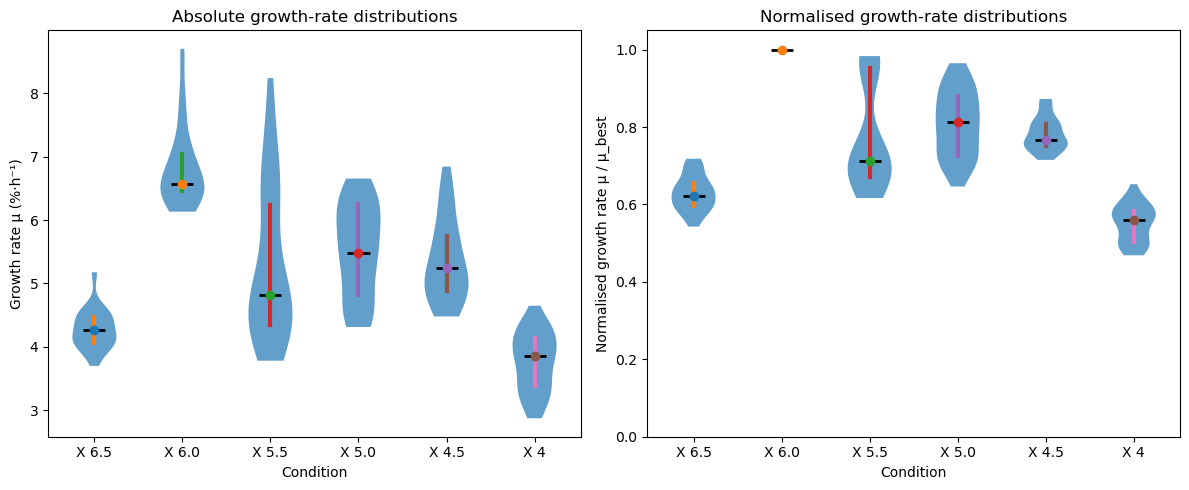

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import linregress

# ============================================================
# DATA LOADING
# ============================================================

def load_data(file_path):
    """Load growth data from CSV."""
    return pd.read_csv(file_path)


def get_biomass_columns(df, prefix="X"):
    """Return biomass column names."""
    return [c for c in df.columns if c.startswith(prefix)]


# ============================================================
# CORE GROWTH-RATE CALCULATION
# ============================================================

def fit_exponential_growth(time, biomass, min_frac, max_frac):
    """
    Fit ln(X) = μt + b over a fractional biomass window.

    Returns
    -------
    dict or None
        Contains μ (%/h), R², duration, or None if fit invalid.
    """
    Xmax = biomass.max()
    mask = (biomass > min_frac * Xmax) & (biomass < max_frac * Xmax)

    t_sel = time[mask]
    X_sel = biomass[mask]

    if len(t_sel) < 2:
        return None

    lnX = np.log(X_sel)
    res = linregress(t_sel, lnX)

    return {
        "mu_pct": res.slope * 100.0,
        "r2": res.rvalue**2,
        "duration": t_sel.max() - t_sel.min(),
        "stderr": res.stderr,
        "n": len(t_sel)
    }


# ============================================================
# SINGLE-WINDOW SUMMARY (Snippet 1)
# ============================================================

def summarise_growth_rates(df, min_fraction=0.1, max_fraction=0.5):
    """
    Compute growth-rate summary table for a single exponential window.
    """
    time = df.iloc[:, 0]
    biomass_cols = get_biomass_columns(df)

    rows = []

    for col in biomass_cols:
        fit = fit_exponential_growth(time, df[col], min_fraction, max_fraction)
        if fit is None:
            continue

        rows.append({
            "Condition": col.replace("X ", ""),
            "Exponential phase duration (h)": round(fit["duration"], 1),
            "Growth rate μ (%/h)": round(fit["mu_pct"], 2),
            "R²": round(fit["r2"], 3)
        })

    return pd.DataFrame(rows)


# ============================================================
# (β, α) SWEEP ANALYSIS (Snippet 2)
# ============================================================

def sweep_growth_rates(
    df,
    beta_grid,
    alpha_grid,
    min_points=8,
    min_duration=8.0,
    r2_threshold=0.8
):
    """
    Perform (β, α) sweep and return absolute and normalised μ distributions.
    """
    time = df.iloc[:, 0]
    biomass_cols = get_biomass_columns(df)

    mu_abs = {col: [] for col in biomass_cols}
    mu_norm = {col: [] for col in biomass_cols}

    for beta in beta_grid:
        for alpha in alpha_grid:

            mu_current = {}
            valid = True

            for col in biomass_cols:
                fit = fit_exponential_growth(time, df[col], beta, alpha)

                if (
                    fit is None or
                    fit["n"] < min_points or
                    fit["duration"] < min_duration or
                    fit["r2"] < r2_threshold
                ):
                    valid = False
                    break

                mu_current[col] = fit["mu_pct"]

            if not valid:
                continue

            mu_max = max(mu_current.values())

            for col, mu in mu_current.items():
                mu_abs[col].append(mu)
                mu_norm[col].append(mu / mu_max)

    return mu_abs, mu_norm


# ============================================================
# PLOTTING UTILITIES
# ============================================================

def plot_violin(ax, data, ylabel, title, ylim=None):
    """Generic violin-plot helper."""
    vp = ax.violinplot(
        data,
        showmeans=False,
        showmedians=True,
        showextrema=False
    )

    for body in vp["bodies"]:
        body.set_alpha(0.7)

    vp["cmedians"].set_color("black")
    vp["cmedians"].set_linewidth(2)

    for i, d in enumerate(data, start=1):
        q1, med, q3 = np.percentile(d, [25, 50, 75])
        ax.plot([i, i], [q1, q3], linewidth=3)
        ax.scatter(i, med, zorder=3)

    ax.set_ylabel(ylabel)
    ax.set_title(title)

    if ylim is not None:
        ax.set_ylim(*ylim)


def plot_absolute_and_normalised_violins(mu_abs, mu_norm):
    """Plot absolute and normalised growth-rate violins side by side."""
    conditions = [c for c in mu_abs if len(mu_abs[c]) > 0]

    data_abs = [mu_abs[c] for c in conditions]
    data_norm = [mu_norm[c] for c in conditions]

    fig, axes = plt.subplots(
        1, 2,
        figsize=(2.0 * len(conditions), 5),
        sharex=True
    )

    plot_violin(
        axes[0],
        data_abs,
        ylabel="Growth rate μ (%·h⁻¹)",
        title="Absolute growth-rate distributions"
    )

    plot_violin(
        axes[1],
        data_norm,
        ylabel="Normalised growth rate μ / μ_best",
        title="Normalised growth-rate distributions",
        ylim=(0, 1.05)
    )

    for ax in axes:
        ax.set_xticks(np.arange(1, len(conditions) + 1))
        ax.set_xticklabels(conditions)
        ax.set_xlabel("Condition")

    plt.tight_layout()
    plt.show()


# ============================================================
# EXAMPLE WORKFLOW
# ============================================================

file_path = "MPR18112025CSV - Sheet1.csv"
df = load_data(file_path)

# Single-window summary
summary_df = summarise_growth_rates(df, min_fraction=0.1, max_fraction=0.5)
display(summary_df)

# Sweep analysis
beta_grid  = np.linspace(0.02, 0.20, 20)
alpha_grid = np.linspace(0.20, 0.80, 25)

mu_abs, mu_norm = sweep_growth_rates(
    df,
    beta_grid,
    alpha_grid,
    min_points=8,
    min_duration=8,
    r2_threshold=0.8
)

# Plot results
plot_absolute_and_normalised_violins(mu_abs, mu_norm)


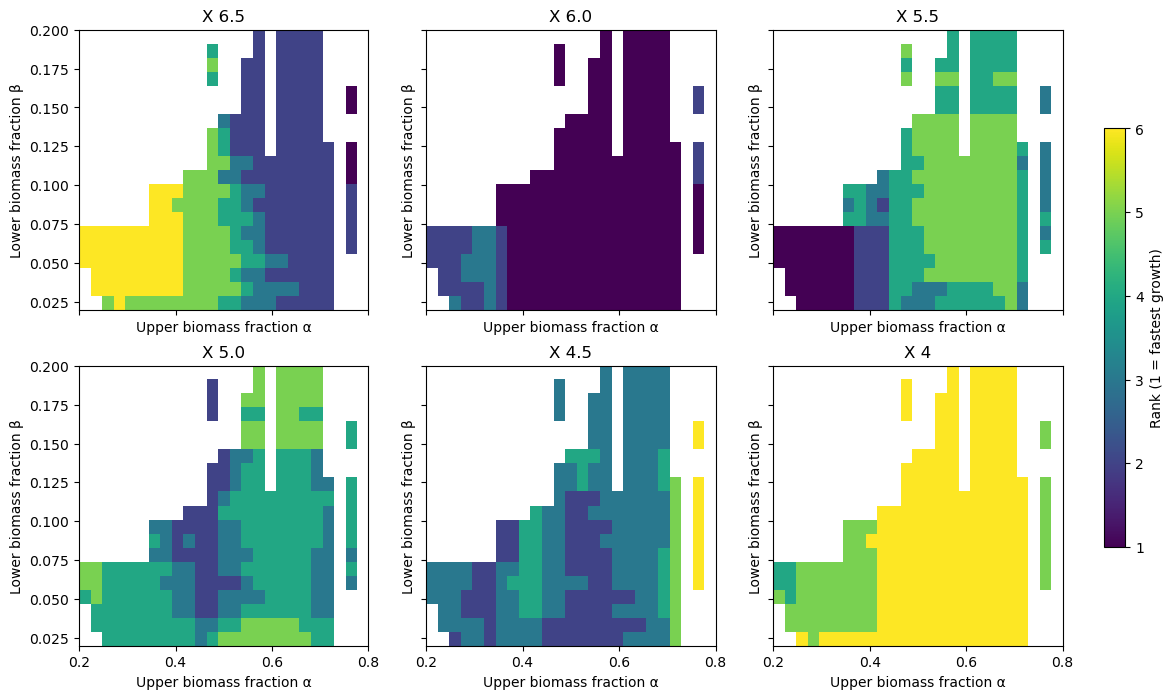

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================================
# USER INPUTS
# ============================================================

time_col = df.columns[0]
time = df[time_col]
biomass_cols = get_biomass_columns(df)

beta_grid  = np.linspace(0.02, 0.20, 20)
alpha_grid = np.linspace(0.20, 0.80, 25)

min_points   = 5
min_duration = 5.0   # hours
r2_threshold = 0.7

# ============================================================
# COMPUTE RANKS OVER (β, α)
# ============================================================

def compute_rank_surfaces(
    df,
    beta_grid,
    alpha_grid,
    min_points,
    min_duration,
    r2_threshold
):
    """
    Compute rank surfaces for each condition over (β, α).
    """
    time = df.iloc[:, 0]
    biomass_cols = get_biomass_columns(df)

    ranks = {
        col: np.full((len(beta_grid), len(alpha_grid)), np.nan)
        for col in biomass_cols
    }

    for i, beta in enumerate(beta_grid):
        for j, alpha in enumerate(alpha_grid):

            mu_estimates = {}
            valid = True

            for col in biomass_cols:
                fit = fit_exponential_growth(
                    time=time,
                    biomass=df[col],
                    min_frac=beta,
                    max_frac=alpha
                )

                if (
                    fit is None or
                    fit["n"] < min_points or
                    fit["duration"] < min_duration or
                    fit["r2"] < r2_threshold
                ):
                    valid = False
                    break

                mu_estimates[col] = fit["mu_pct"]  # %/h

            if not valid:
                continue

            # Rank by μ (highest μ = rank 1)
            ranked = sorted(
                mu_estimates.items(),
                key=lambda x: x[1],
                reverse=True
            )

            for rank, (col, _) in enumerate(ranked, start=1):
                ranks[col][i, j] = rank

    return ranks


# ============================================================
# PLOTTING: RANK HEATMAPS
# ============================================================

def plot_rank_heatmaps(ranks, beta_grid, alpha_grid):
    """Plot all rank heatmaps in a single figure with shared colorbar."""
    biomass_cols = list(ranks.keys())
    n_conditions = len(biomass_cols)

    n_cols = 3
    n_rows = int(np.ceil(n_conditions / n_cols))

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(4.5 * n_cols, 4.0 * n_rows),
        sharex=True,
        sharey=True
    )

    axes = np.array(axes).reshape(-1)

    vmin, vmax = 1, n_conditions

    for ax, col in zip(axes, biomass_cols):
        im = ax.imshow(
            ranks[col],
            origin="lower",
            aspect="auto",
            extent=[
                alpha_grid.min(),
                alpha_grid.max(),
                beta_grid.min(),
                beta_grid.max()
            ],
            vmin=vmin,
            vmax=vmax
        )

        ax.set_title(col)
        ax.set_xlabel("Upper biomass fraction α")
        ax.set_ylabel("Lower biomass fraction β")

    # Disable unused subplots
    for ax in axes[len(biomass_cols):]:
        ax.axis("off")

    # Shared colorbar
    cbar = fig.colorbar(
        im,
        ax=axes.tolist(),
        orientation="vertical",
        fraction=0.02,
        pad=0.04
    )
    cbar.set_label("Rank (1 = fastest growth)")

    plt.show()


# ============================================================
# RUN ANALYSIS
# ============================================================

ranks = compute_rank_surfaces(
    df=df,
    beta_grid=beta_grid,
    alpha_grid=alpha_grid,
    min_points=min_points,
    min_duration=min_duration,
    r2_threshold=r2_threshold
)

plot_rank_heatmaps(ranks, beta_grid, alpha_grid)


<Axes: title={'center': 'Biomass Growth Curves'}, xlabel='Time (h)', ylabel='Biomass (g/L)'>

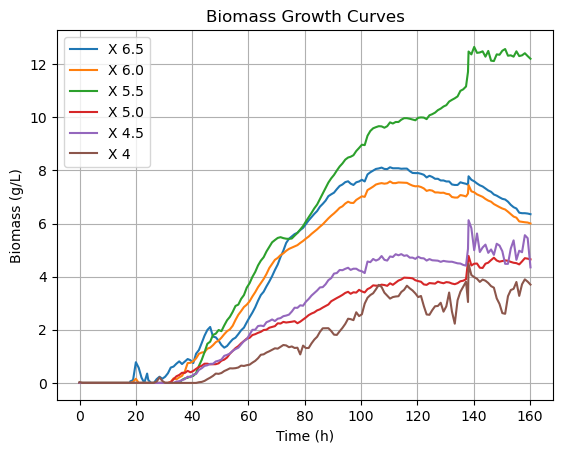

In [41]:
biomass_cols = get_biomass_columns(df)

df.plot('Time (h)', biomass_cols, grid=True, xlabel='Time (h)', ylabel='Biomass (g/L)', title='Biomass Growth Curves')

In [42]:
import numpy as np
import pandas as pd
from typing import Dict, Optional
from scipy.optimize import least_squares
from scipy.integrate import solve_ivp

# -----------------------------
# Utilities
# -----------------------------
def prepare_time_series(time, X):
    tmp = pd.DataFrame({"time": np.asarray(time), "X": np.asarray(X)})
    tmp = tmp.sort_values("time").drop_duplicates(subset="time")
    tmp = tmp[np.isfinite(tmp["X"]) & np.isfinite(tmp["time"])]
    tmp = tmp[tmp["X"] > 0]
    return tmp["time"].values, tmp["X"].values

def metrics(y_true, y_pred) -> Dict[str, float]:
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    resid = y_pred - y_true
    mae = float(np.mean(np.abs(resid)))
    rmse = float(np.sqrt(np.mean(resid**2)))
    ss_res = float(np.sum(resid**2))
    ss_tot = float(np.sum((y_true - np.mean(y_true))**2))
    r2 = float(1.0 - ss_res / ss_tot) if ss_tot > 0 else np.nan
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

# -----------------------------
# Model A: Lagged exponential with yield cap (Yxs FIXED)
# -----------------------------
def predict_lagged_exponential_cap(time, X0, S0, mu_max, lag, Yxs_fixed):
    t = np.asarray(time)
    X_cap = X0 + Yxs_fixed * S0
    X_pred = np.full_like(t, fill_value=X0, dtype=float)
    grow = t > lag
    X_pred[grow] = X0 * np.exp(mu_max * (t[grow] - lag))
    return np.minimum(X_pred, X_cap)

def fit_lagged_exponential_cap_fixedYxs(
    time, X_obs, *, S0=15.0, Yxs_fixed=0.5,
    lag_grid=None, loss="soft_l1", f_scale=0.1
):
    """
    Robust fit of (mu_max, lag) with Yxs fixed.
    """
    time, X_obs = prepare_time_series(time, X_obs)
    X0 = float(X_obs[0])

    if lag_grid is None:
        lag_grid = np.linspace(time.min(), time.min() + 0.33*(time.max()-time.min()), 40)

    bounds = (
        np.array([1e-4, 0.0]),            # mu_max, lag
        np.array([2.0,  time.max()])
    )

    best = None

    def resid(p):
        mu, lag = p
        X_pred = predict_lagged_exponential_cap(time, X0, S0, mu, lag, Yxs_fixed)
        return X_pred - X_obs

    for lag0 in lag_grid:
        p0 = np.array([0.2, float(lag0)])
        p0 = np.maximum(p0, bounds[0] + 1e-12)
        p0 = np.minimum(p0, bounds[1] - 1e-12)

        res = least_squares(resid, p0, bounds=bounds, loss=loss, f_scale=f_scale)

        if best is None or res.cost < best["opt"].cost:
            X_fit = predict_lagged_exponential_cap(time, X0, S0, res.x[0], res.x[1], Yxs_fixed)
            best = {
                "model": "lagged_exponential_cap_fixedYxs",
                "params": {"mu_max": res.x[0], "lag": res.x[1], "Yxs": float(Yxs_fixed)},
                "opt": res,
                "fit_metrics": metrics(X_obs, X_fit),
                "time": time,
                "X_obs": X_obs,
                "X_pred": X_fit
            }

    return best

# -----------------------------
# Model B: Lagged Monod (Ks ALWAYS FREE, Yxs FIXED)
# -----------------------------
def monod_lag_odes(t, y, mu_max, Ks, Yxs_fixed, lag):
    X, S = y
    if t < lag:
        mu = 0.0
    else:
        mu = mu_max * (S / (Ks + S)) if S > 0 else 0.0
    dXdt = mu * X
    dSdt = -(1.0 / Yxs_fixed) * dXdt
    return [dXdt, dSdt]

def simulate_monod_lag(time, X0, S0, mu_max, Ks, Yxs_fixed, lag):
    t = np.asarray(time)
    sort_idx = np.argsort(t)
    t_sorted = t[sort_idx]

    sol = solve_ivp(
        monod_lag_odes,
        t_span=(t_sorted.min(), t_sorted.max()),
        y0=[X0, S0],
        t_eval=t_sorted,
        args=(mu_max, Ks, Yxs_fixed, lag),
        method="RK45"
    )

    Xs, Ss = sol.y
    X = np.empty_like(Xs); S = np.empty_like(Ss)
    X[sort_idx] = Xs; S[sort_idx] = Ss
    return X, S

def fit_monod_lag_fixedYxs(
    time, X_obs, *, S0=15.0, Yxs_fixed=0.5,
    lag_grid=None, loss="soft_l1", f_scale=0.1
):
    """
    Robust Monod+lag fit with Ks free and Yxs fixed: fits (mu_max, Ks, lag).
    """
    time, X_obs = prepare_time_series(time, X_obs)
    X0 = float(X_obs[0])

    if lag_grid is None:
        lag_grid = np.linspace(time.min(), time.min() + 0.33*(time.max()-time.min()), 40)

    bounds = (
        np.array([0.01, 0.01, 0.0]),          # mu_max, Ks, lag
        np.array([0.50, 20.0, time.max()])
    )

    best = None

    def resid(p):
        mu_max, Ks, lag = p
        X_pred, _ = simulate_monod_lag(time, X0, S0, mu_max, Ks, Yxs_fixed, lag)
        return X_pred - X_obs

    for lag0 in lag_grid:
        p0 = np.array([0.2, 0.5, float(lag0)])
        p0 = np.maximum(p0, bounds[0] + 1e-12)
        p0 = np.minimum(p0, bounds[1] - 1e-12)

        res = least_squares(resid, p0, bounds=bounds, loss=loss, f_scale=f_scale)

        if best is None or res.cost < best["opt"].cost:
            X_fit, S_fit = simulate_monod_lag(time, X0, S0, res.x[0], res.x[1], Yxs_fixed, res.x[2])
            best = {
                "model": "monod_lag_fixedYxs",
                "params": {"mu_max": res.x[0], "Ks": res.x[1], "Yxs": float(Yxs_fixed), "lag": res.x[2]},
                "opt": res,
                "fit_metrics": metrics(X_obs, X_fit),
                "time": time,
                "X_obs": X_obs,
                "X_pred": X_fit,
                "S_pred": S_fit
            }

    return best

# -----------------------------
# Wrapper: compare both models (Yxs fixed for both; Ks free only in Monod)
# -----------------------------
def fit_one_series_both_models(time, X_obs, *, S0=15.0, Yxs_fixed=0.5):
    fit_exp = fit_lagged_exponential_cap_fixedYxs(time, X_obs, S0=S0, Yxs_fixed=Yxs_fixed)
    fit_mon = fit_monod_lag_fixedYxs(time, X_obs, S0=S0, Yxs_fixed=Yxs_fixed)

    chosen = fit_exp if fit_exp["fit_metrics"]["MAE"] <= fit_mon["fit_metrics"]["MAE"] else fit_mon
    return chosen, {"exp_cap": fit_exp, "monod": fit_mon}


In [43]:
# Example usage for one condition column in df:
time = df.iloc[:, 0].values
X_obs = df["X 6.0"].values  # change to your condition

chosen, allfits = fit_one_series_both_models(time, X_obs, S0=15.0, Yxs_fixed=0.5)

print("Chosen model:", chosen["model"])
print("Params:", chosen["params"])
print("Fit metrics:", chosen["fit_metrics"])

print("Alternative model params:", allfits['exp_cap']['params'])
print("Fit metrics:", allfits['exp_cap']['fit_metrics'])

Chosen model: monod_lag_fixedYxs
Params: {'mu_max': 0.25120493867910104, 'Ks': 19.99700135233956, 'Yxs': 0.5, 'lag': 21.38953846153846}
Fit metrics: {'MAE': 0.6087896417893486, 'RMSE': 0.7443016433131379, 'R2': 0.9033595352928512}
Alternative model params: {'mu_max': 0.06831529560143151, 'lag': 9.311269226200985e-15, 'Yxs': 0.5}
Fit metrics: {'MAE': 0.6500842903242294, 'RMSE': 0.8783278957846195, 'R2': 0.8654218957258609}


In [44]:
yield_df = pd.read_csv("pHvsYield.csv")
yield_df.head()
yield_dict = dict(zip(yield_df['pH'], yield_df['Yield (g/g)']))

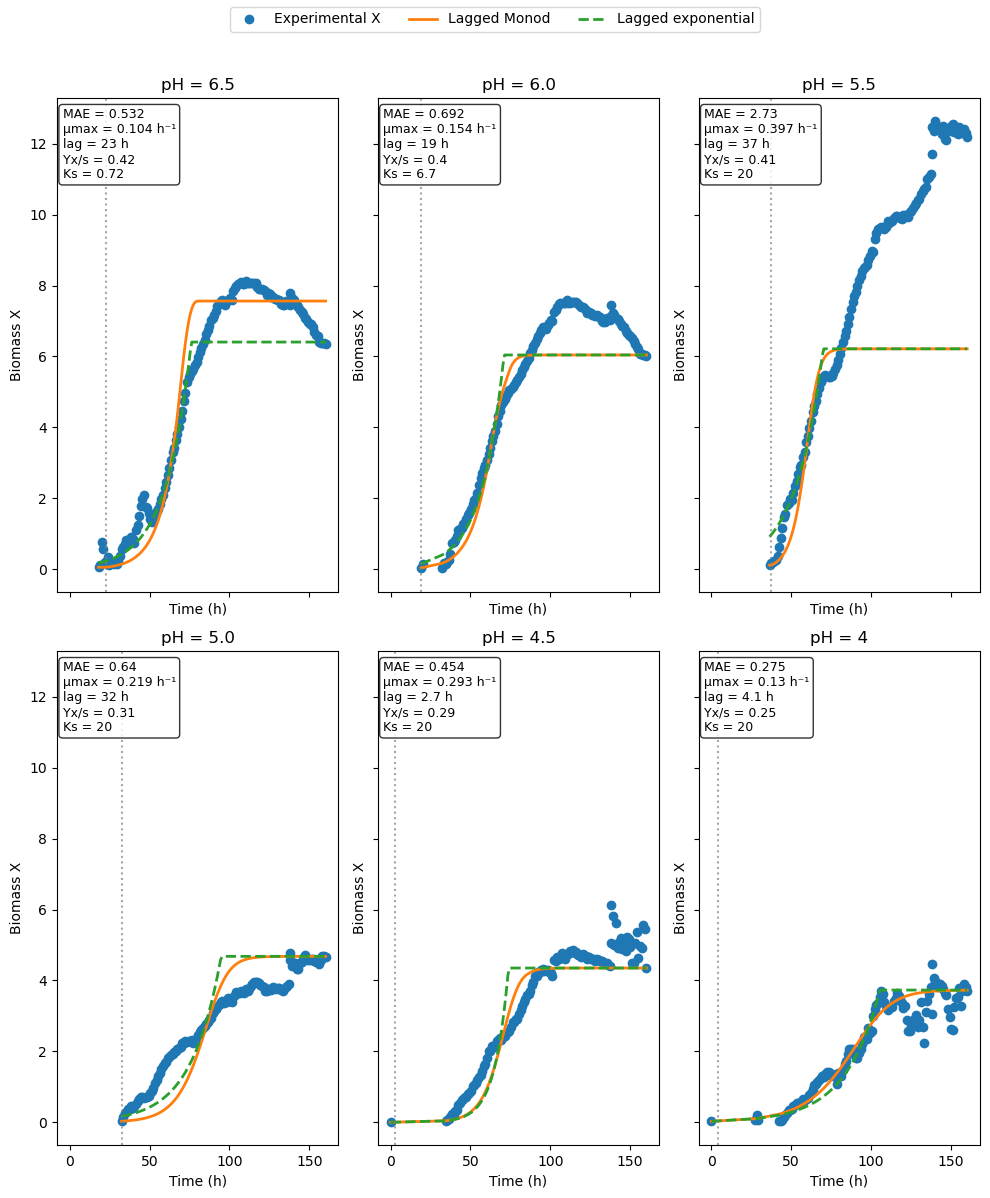

In [46]:
def plot_models_one_condition_ax(
    ax,
    time,
    X_obs,
    fit_monod,
    fit_exp,
    S0=15.0,
    label="Condition"
):
    # clean/sort
    time, X_obs = prepare_time_series(time, X_obs)
    X0 = float(X_obs[0])

    # predictions
    Xm, _ = simulate_monod_lag(
        time, X0, S0,
        fit_monod["params"]["mu_max"],
        fit_monod["params"]["Ks"],
        fit_monod["params"]["Yxs"],
        fit_monod["params"]["lag"]
    )

    Xe = predict_lagged_exponential_cap(
        time, X0, S0,
        fit_exp["params"]["mu_max"],
        fit_exp["params"]["lag"],
        fit_exp["params"]["Yxs"]
    )

    # plot on provided axis
    ax.plot(time, X_obs, "o", label="Experimental X")
    ax.plot(time, Xm, "-",  lw=2, label="Lagged Monod")
    ax.plot(time, Xe, "--", lw=2, label="Lagged exponential")

    ax.set_title("pH = " + label)
    ax.axvline(fit_monod["params"]["lag"], color="gray", linestyle=":", alpha=0.7)
    ax.set_xlabel("Time (h)")
    ax.set_ylabel("Biomass X")

        # -------------------------
    # Annotation text
    # -------------------------
    mae_m = fit_monod["fit_metrics"]["MAE"]
    p_m = fit_monod["params"]

    text = (
        f"MAE = {mae_m:.3g}\n"
        f"μmax = {p_m['mu_max']:.3g} h⁻¹\n"
        f"lag = {p_m['lag']:.2g} h\n"
        f"Yx/s = {p_m['Yxs']:.2g}"
    )

    if "Ks" in p_m:
        text += f"\nKs = {p_m['Ks']:.2g}"

    # place text in upper-left of subplot
    ax.text(
        0.02, 0.98,
        text,
        transform=ax.transAxes,
        ha="left",
        va="top",
        fontsize=9,
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8)
    )

fig, axes = plt.subplots(
    nrows=2,
    ncols=3,
    figsize=(10, 12),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

time_all = df.iloc[:, 0].values

for i, col in enumerate(biomass_cols):
    pH = col.replace("X ", "")
    pH = float(pH)
    ax = axes[i]
    X_obs = df[col].values

    chosen, allfits = fit_one_series_both_models(
        time_all,
        X_obs,
        S0=15.0,
        Yxs_fixed=yield_dict[pH]
    )

    ph = col.replace("X ", "")

    for model_name, fit in allfits.items():
        row = {
            "pH": ph,
            "model": model_name,
            **fit["params"],
            **fit["fit_metrics"]
        }
        rows = []
        rows.append(row)
        try:
            param_df = pd.read_csv("growth_model_parameters.csv")
        except FileNotFoundError:
            param_df = pd.DataFrame()
        param_df = pd.concat([param_df, pd.DataFrame(rows)], ignore_index=True)
        param_df.to_csv("growth_model_parameters.csv", index=False)

    plot_models_one_condition_ax(
        ax=ax,
        time=time_all,
        X_obs=X_obs,
        fit_monod=allfits["monod"],
        fit_exp=allfits["exp_cap"],
        S0=15.0,
        label=col.replace("X ", "")
    )

# Turn off any unused axes (safety)
for ax in axes[len(biomass_cols):]:
    ax.axis("off")

# Single shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3)


plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
param_df = pd.read_csv("growth_model_parameters.csv")
param_df.head()


,pH,model,mu_max,lag,Yxs,MAE,RMSE,R2,Ks
0,6.5,exp_cap,0.061884,2.504412e-15,0.993980,0.759606,1.070659,0.965002,NaN
1,6.5,monod,0.216926,1.796987e+01,1.000000,0.666364,0.922327,0.974028,20.000000
2,6.0,exp_cap,0.069049,1.040656e-14,0.922590,0.965141,1.300999,0.926183,NaN
3,6.0,monod,0.261084,2.019477e+01,0.907715,0.907208,1.066050,0.950437,19.984589
4,5.5,exp_cap,0.048934,1.036340e-16,0.675143,1.093490,1.319188,0.877586,NaN


/var/folders/lt/wl_tgfbd2dz1wbt6952jcc8w0000gn/T/ipykernel_43664/2244990698.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m["pH"] = pd.to_numeric(df_m["pH"])


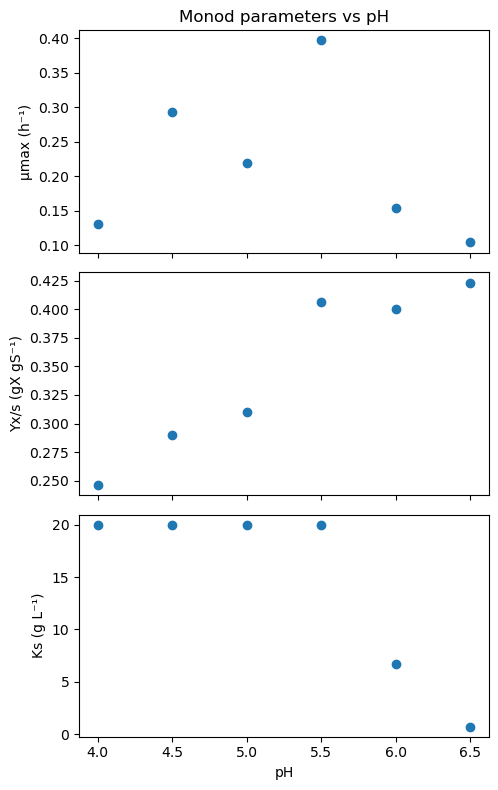

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("growth_model_parameters.csv")

# Keep only Monod fits (Ks is undefined for exp_cap)
df_m = df[df["model"].str.contains("monod")]

# Ensure numeric pH
df_m["pH"] = pd.to_numeric(df_m["pH"])

fig, axes = plt.subplots(
    nrows=3,
    ncols=1,
    figsize=(5, 8),
    sharex=True
)

# μmax vs pH
axes[0].scatter(df_m["pH"], df_m["mu_max"])
axes[0].set_ylabel("μmax (h⁻¹)")
axes[0].set_title("Monod parameters vs pH")

# Yx/s vs pH
axes[1].scatter(df_m["pH"], df_m["Yxs"])
axes[1].set_ylabel("Yx/s (gX gS⁻¹)")

# Ks vs pH
axes[2].scatter(df_m["pH"], df_m["Ks"])
axes[2].set_ylabel("Ks (g L⁻¹)")
axes[2].set_xlabel("pH")

plt.tight_layout()
plt.show()


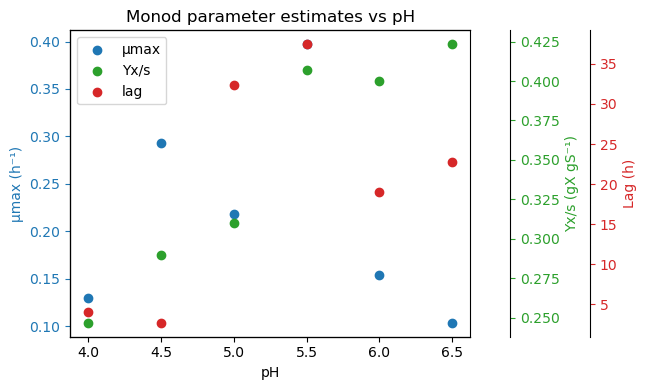

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("growth_model_parameters.csv")

# Keep only Monod fits
df_m = df[df["model"].str.contains("monod")].copy()
df_m["pH"] = pd.to_numeric(df_m["pH"])

# Sort for nicer visuals
df_m = df_m.sort_values("pH")

# --- Create a single plot with multiple y-axes (all color-coded) ---
fig, ax_mu = plt.subplots(figsize=(7, 4))

# μmax axis (left)
p1 = ax_mu.scatter(df_m["pH"], df_m["mu_max"], label="μmax", color="C0")
ax_mu.set_xlabel("pH")
ax_mu.set_ylabel("μmax (h⁻¹)", color="C0")
ax_mu.tick_params(axis="y", colors="C0")

# Ks axis (right)
#ax_Ks = ax_mu.twinx()
#p2 = ax_Ks.scatter(df_m["pH"], df_m["Ks"], label="Ks", color="C1")
#ax_Ks.set_ylabel("Ks (g L⁻¹)", color="C1")
#ax_Ks.tick_params(axis="y", colors="C1")

# Yx/s axis (extra right, offset)
ax_Y = ax_mu.twinx()
ax_Y.spines["right"].set_position(("axes", 1.1))
p3 = ax_Y.scatter(df_m["pH"], df_m["Yxs"], label="Yx/s", color="C2")
ax_Y.set_ylabel("Yx/s (gX gS⁻¹)", color="C2")
ax_Y.tick_params(axis="y", colors="C2")

# lag axis (extra right, further offset)
ax_lag = ax_mu.twinx()
ax_lag.spines["right"].set_position(("axes", 1.30))
p4 = ax_lag.scatter(df_m["pH"], df_m["lag"], label="Lag", color="C3")
ax_lag.set_ylabel("Lag (h)", color="C3")
ax_lag.tick_params(axis="y", colors="C3")

# Title + legend
ax_mu.set_title("Monod parameter estimates vs pH")
handles = [p1, p3, p4]
labels = ["μmax", "Yx/s", "lag"]
ax_mu.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()


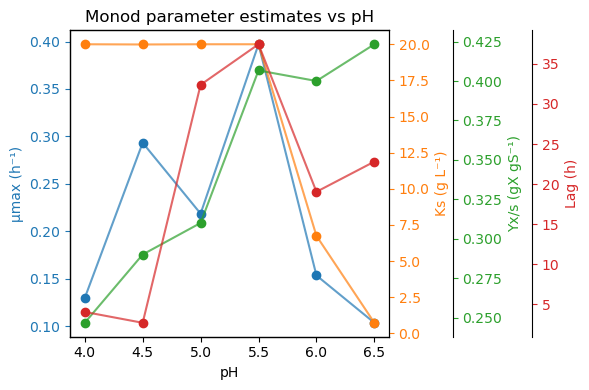

In [71]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("growth_model_parameters.csv")

# Keep only Monod fits
df_m = df[df["model"].str.contains("monod")].copy()
df_m["pH"] = pd.to_numeric(df_m["pH"])

# Sort for nicer visuals
df_m = df_m.sort_values("pH")

# --- Create a single plot with multiple y-axes (all color-coded) ---
fig, ax_mu = plt.subplots(figsize=(7, 4))

# μmax axis (left)
p1 = ax_mu.scatter(df_m["pH"], df_m["mu_max"], color="C0", zorder=3)
ax_mu.plot(df_m["pH"], df_m["mu_max"], color="C0", alpha=0.7)
ax_mu.set_xlabel("pH")
ax_mu.set_ylabel("μmax (h⁻¹)", color="C0")
ax_mu.tick_params(axis="y", colors="C0")

# Ks axis (right)
ax_Ks = ax_mu.twinx()
p2 = ax_Ks.scatter(df_m["pH"], df_m["Ks"], label="Ks", color="C1")
ax_Ks.plot(df_m["pH"], df_m["Ks"], color="C1", alpha=0.7)
ax_Ks.set_ylabel("Ks (g L⁻¹)", color="C1")
ax_Ks.tick_params(axis="y", colors="C1")

# Yx/s axis (extra right, offset)
ax_Y = ax_mu.twinx()
ax_Y.spines["right"].set_position(("axes", 1.2))
p3 = ax_Y.scatter(df_m["pH"], df_m["Yxs"], color="C2", zorder=3)
ax_Y.plot(df_m["pH"], df_m["Yxs"], color="C2", alpha=0.7)
ax_Y.set_ylabel("Yx/s (gX gS⁻¹)", color="C2")
ax_Y.tick_params(axis="y", colors="C2")

# lag axis (extra right, further offset)
ax_lag = ax_mu.twinx()
ax_lag.spines["right"].set_position(("axes", 1.45))
p4 = ax_lag.scatter(df_m["pH"], df_m["lag"], color="C3", zorder=3)
ax_lag.plot(df_m["pH"], df_m["lag"], color="C3", alpha=0.7)
ax_lag.set_ylabel("Lag (h)", color="C3")
ax_lag.tick_params(axis="y", colors="C3")

# Title + legend
ax_mu.set_title("Monod parameter estimates vs pH")
handles = [p1, p2, p3, p4]
labels = ["μmax", "Ks", "Yx/s", "Lag"]
#ax_mu.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()


# Need to add S_end = 0 condition on parameter estimation.